# Raster Operations

Tranformations involving raster data. Reclassification, local operations, focal operations, zonal operations, and global operations

## Loading libraries

In [1]:
# Load relevant R packages
inLibraries = list('repr','spdep','raster','rgdal')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Warning message:
"package 'spdep' was built under R version 3.4.2"Warning message:
"package 'sp' was built under R version 3.4.2"Warning message:
"package 'raster' was built under R version 3.4.2"Warning message:
"package 'rgdal' was built under R version 3.4.2"

## Raster Operations

There are a variety of raster operations supported by functions in R. Let's explore a few of these using a digital elevation model (DEM raster (taneycomo/TaneyDEM1) and a line vector featureclass (taneycomo/taneyhydro.shp).  

More info on DEMs can be found at:

-https://www.usgs.gov/faqs/what-are-digital-elevation-models-dems


In [5]:
# read raster daa
ras_name <- "datasets/taneycomo/TaneyDEM1.tif"
inRas <- raster(ras_name, values = TRUE)

In [17]:
# read in the shp file
rivers <- readOGR("datasets/taneycomo", "taneyhydro")

OGR data source with driver: ESRI Shapefile 
Source: "datasets/taneycomo", layer: "taneyhydro"
with 192 features
It has 11 fields
Integer64 fields read as strings:  OBJECTID FNODE_ TNODE_ LPOLY_ RPOLY_ HISTHYDRO_ HISTHYDRO1 


In [19]:
names(rivers)

[1] "OBJECTID"   "FNODE_"     "TNODE_"     "LPOLY_"     "RPOLY_"    
 [6] "LENGTH"     "HISTHYDRO_" "HISTHYDRO1" "BANK"       "NAME"      
[11] "Shape_Leng"

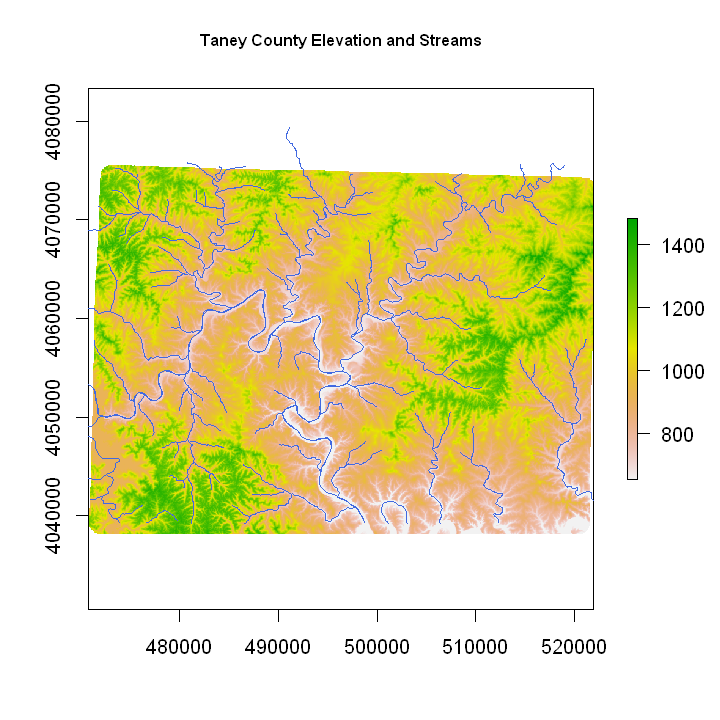

In [14]:
# display the raster
plot(inRas, topo.colors, main = "Taney County Elevation and Streams", cex.main = 0.8)
plot(rivers, add = TRUE, col = "royalblue")

In [16]:
inRas

class       : RasterLayer 
dimensions  : 1248, 1707, 2130336  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 470754.2, 521964.2, 4038163, 4075603  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0 
data source : C:\Users\Jacky Zhao\Desktop\repos\R-Data\datasets\taneycomo\TaneyDEM1.tif 
names       : TaneyDEM1 


## Local Operation - Reclassify

In this dataset, the numbers associated with each cell represent the elevation of that cell. The elevation ranges from 652' to 1483'.  What if we wanted to change each cell value to represent a specific elevation zone.  For example, cells with elevations 0-700' would be zone 1, 700-800' zone 2, etc.  Such changes to cell values are called reclassification. The reclassify() function (raster library) can assist with this task. This function requires a matrix that contains the beginning and ending value range and the new value that will be used to represent that range. In the example below, 9 different ranges are considered.  However, try to modify these ranges and see what happens. What does the right=NA argument in the reclassification tool do? Answer - look it up in the raster library manual!

Notice that the reclassified raster only contains values between 1 and 9 now.

In [22]:
# construct reclassify table
oldnewclasses <- c(0, 700, 1, 
                  700, 800, 2,
                  800, 900, 3, 
                  900, 1000, 4,
                  1000, 1100, 5,
                  1100, 1200, 6,
                  1200, 1300, 7,
                  1300, 1400, 8,
                  1400, 1500, 9)

oldnewclasses

[1]    0  700    1  700  800    2  800  900    3  900 1000    4 1000 1100    5
[16] 1100 1200    6 1200 1300    7 1300 1400    8 1400 1500    9

In [24]:
rcl <- matrix(oldnewclasses, ncol = 3, byrow = TRUE)
rcl

0,700,1
700,800,2
800,900,3
900,1000,4
1000,1100,5
1100,1200,6
1200,1300,7
1300,1400,8
1400,1500,9


In [26]:
# reclassify the dataset to create a new raster
rcRaster <- reclassify(inRas, rcl, right = NA)
rcRaster

class       : RasterLayer 
dimensions  : 1248, 1707, 2130336  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 470754.2, 521964.2, 4038163, 4075603  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0 
data source : in memory
names       : layer 
values      : 1, 9  (min, max)


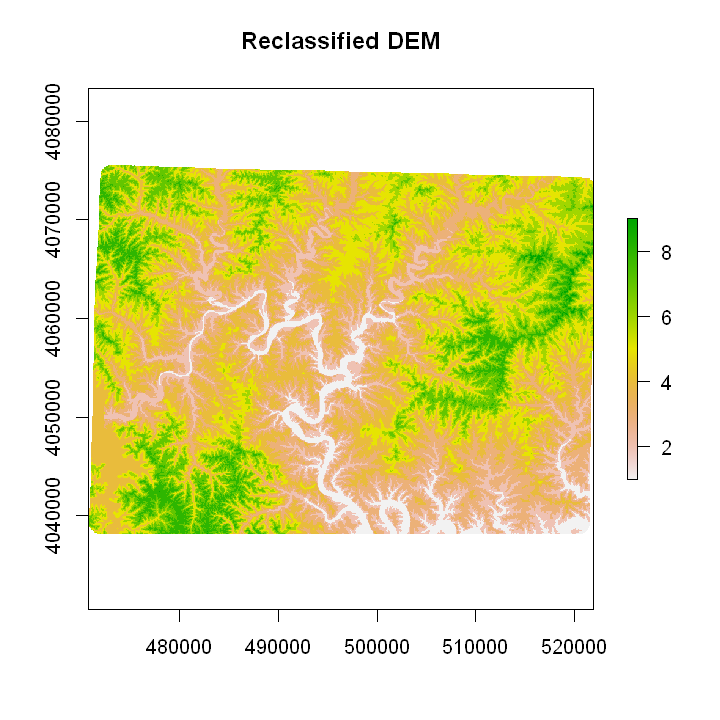

In [30]:
# display the raster
plot(rcRaster, main = "Reclassified DEM")

## Focal Functions

Focal functions can be applied to examine the values in a neighborhood surrounding a cell. Using the focal() function (raster library), any function can be applied to a neighborhood (fun). However, the neighborhood must have an odd number or rows and columns. Below, a matrix is used to represent the neighborhood window or filter. This matrix can be all 1's or some standardized value as implemented here. 

The cell size of the original DEM is 30m x 30m and in this example a 11 x 11 cell neighborhood around each cell is examined.

In [52]:
# construct a focal window matrix
numcols <- 31
numrows <- 31
matsize <- numcols * numrows
matsize

[1] 961

In [53]:
fcl <- matrix((1/matsize), nc = numcols, nr = numrows)
fcl

0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,...,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583
0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,...,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583
0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,...,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583
0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,...,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583
0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,...,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583
0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,...,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583
0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,...,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583
0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,...,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583
0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,...,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583
0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,...,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583
0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,...,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583,0.001040583


### Focal Range

Using the 'range' function (the focal range will be computed). Thus, we can evaluate these neighborhoods and see which areas have a higher range of elevation values and which have a lower range.

In [54]:
# apply focal range
focalRaster <- focal(inRas, w = fcl, fun = range)

In [55]:
focalRaster

class       : RasterLayer 
dimensions  : 1248, 1707, 2130336  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 470754.2, 521964.2, 4038163, 4075603  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0 
data source : in memory
names       : layer 
values      : 0.6784599, 1.314256  (min, max)


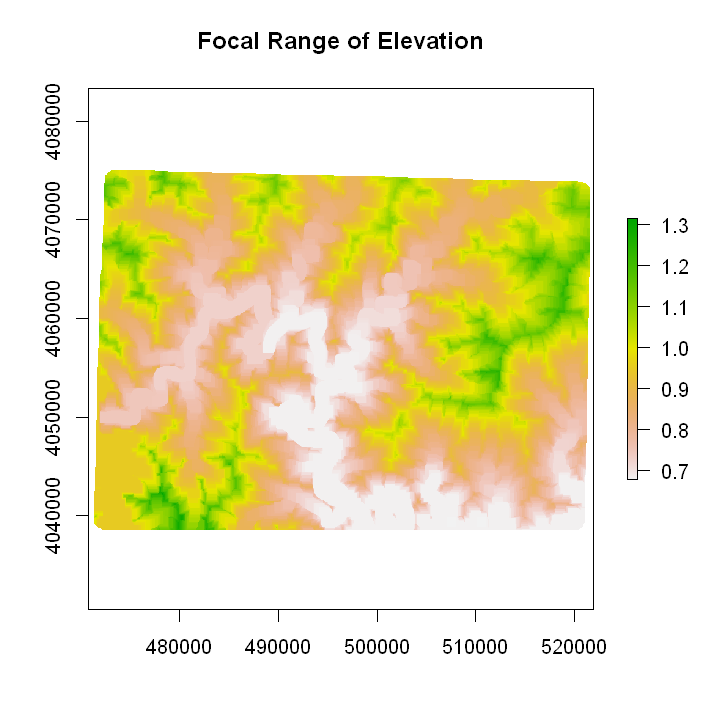

In [56]:
# display the raster
plot(focalRaster, main = "Focal Range of Elevation")

### Slope

Another type of focal function particular to DEMs is that of computing slope. Computation of slope is provided by the terrain() function (raster library). The terrain() function actually allows many landscape functions to be computed such as slope, aspect, flow direction, roughness, among others.  It requires an input DEM, specification of the type of output (i.e. slope), the units for which slope and aspect are computed (yes, there are different ways to measure slope!), as well as the number of neighbors to consider for each cell in the computation of slope (i.e. 4 = Rook's criterion, 8 = Queen's criterion).

In [63]:
# compute slope 
slopeRaster <- terrain(inRas, opt = c("slope", "roughness", "aspect"), unit = "degrees", neighbors = 8)

slopeRaster

class       : RasterBrick 
dimensions  : 1248, 1707, 2130336, 3  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : 470754.2, 521964.2, 4038163, 4075603  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0 
data source : in memory
names       : roughness,     slope,    aspect 
min values  :         0,         0,         0 
max values  : 289.00000,  78.15553, 360.00000 


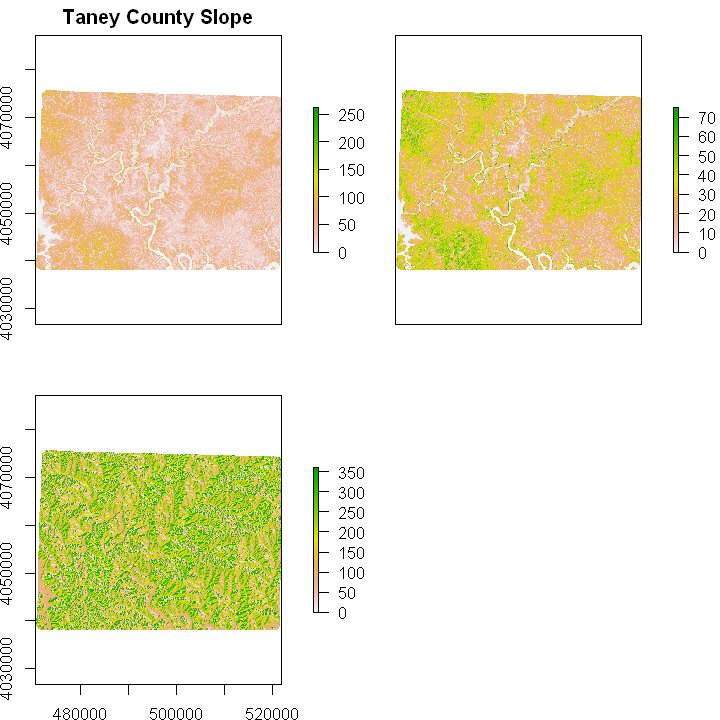

In [64]:
plot(slopeRaster, main = "Taney County Slope")

## Global Functions

Global functions involve application of the same calculation to every cell. For example, consider the case where the task is to find the shortest distance from every cell to a single point. The distanceFromPoints() function (raster library) could be used to do this.  All that is needed is a point's coordinate. Here we'll use the coordinate for Branson Memorial Airport. Notice the x,y coordinate is in meters....b/c the coordinate system is in meters. The coordinate needs to either be a spatialpoints object (i.e. from a shp file imported via rgdal) or entered in a matrix as is done below.


In [65]:
ptcoord <- c(474920.78125, 4055234)
xy <- matrix(ptcoord, nc = 2, byrow = TRUE)
xy

474920.8,4055234


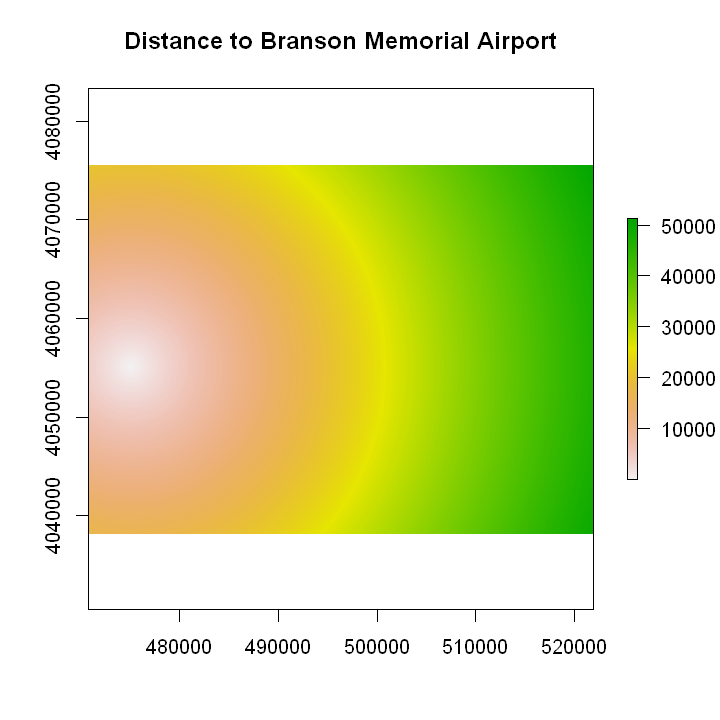

In [66]:
# compute distance to the point
ptRaster <- distanceFromPoints(inRas, xy)

# plot
plot(ptRaster, main = "Distance to Branson Memorial Airport")

## Zonal Functions

Earlier a line vector dataset was imported, river features for the region.  Let's examine the range of elevation values within 100m of the White River.

In [76]:
rivers@data$NAME

[1] Hurricane Creek       Bear Creek            Cook Hollow          
  [4] Bright Hollow         Bull Creek            Bull Creek           
  [7] Gravelly Hollow       Bull Creek            Little Beaver Creek  
 [10] <NA>                  Blue Creek            Beaver Creek         
 [13] <NA>                  Beaver Creek          Hodge Hollow         
 [16] <NA>                  Swan Creek            <NA>                 
 [19] <NA>                  <NA>                  Blue Creek           
 [22] Bull Creek            <NA>                  Bear Creek           
 [25] <NA>                  Swan Creek            Swan Creek           
 [28] Bear Creek            <NA>                  Beaver Creek         
 [31] Beaver Creek          Bear Creek            West Fork Bear Creek 
 [34] Swan Creek            West Fork Bear Creek  <NA>                 
 [37] Swan Creek            Swan Creek            Swan Creek           
 [40] <NA>                  <NA>                  Bear Creek           
 [43] Caney Creek           Swan Creek            Mathis Hollow        
 [46] Bull Creek            Swan Creek            Swan Creek           
 [49] <NA>                  <NA>                  Swan Creek           
 [52] Swan Creek            Stout Creek           <NA>                 
 [55] <NA>                  Swan Creek            <NA>                 
 [58] Bull Creek            Bull Creek            Bull Creek           
 [61] Bull Creek            Bear Creek            <NA>                 
 [64] <NA>                  Stout Creek           Swan Creek           
 [67] Swan Creek            Swan Creek            Swan Creek           
 [70] Swan Creek            Swan Creek            Swan Creek           
 [73] Bull Creek            Bear Creek            Emory Creek          
 [76] North Emory Creek     Emory Creek           Emory Creek          
 [79] Bull Creek            Beaver Creek          Brushy Creek         
 [82] South Emory Creek     Swan Creek            Housemans Branch     
 [85] <NA>                  <NA>                  Winkle Creek         
 [88] Brushy Creek          Bull Creek            East Fork Roark Creek
 [91] West Fork Roark Creek Max Creek             Beaver Creek         
 [94] Beaver Creek          Swan Creek            Bee Creek            
 [97] <NA>                  Long Creek            White River          
[100] Bee Creek             Beaver Creek          Winkle Creek         
[103] White River           White River           Roark Creek          
[106] White River           White River           <NA>                 
[109] <NA>                  Silver Creek          <NA>                 
[112] Beaver Creek          White River           White River          
[115] <NA>                  Cane Creek            <NA>                 
[118] West Fork Big Creek   White River           Turkey Creek         
[121] Cedar Creek           <NA>                  <NA>                 
[124] Cedar Creek           Fall Creek            White River          
[127] <NA>                  White River           Bookout Branch       
[130] Wolf Creek            <NA>                  Coon Creek           
[133] White River           Turkey Creek          <NA>                 
[136] White River           White River           White River          
[139] East Fork Big Creek   West Fork Big Creek   <NA>                 
[142] Trigger Creek         Short Creek           Long Creek           
[145] Turkey Creek          <NA>                  <NA>                 
[148] White River           White River           <NA>                 
[151] <NA>                  <NA>                  Elbow Creek          
[154] <NA>                  Hoosier Branch        Shoal Creek          
[157] Turkey Creek          <NA>                  Yocum Creek          
[160] White River           Mincy Creek           Thorp Creek          
[163] Long Creek            Turkey Creek          <NA>                 
[166] <NA>                  <NA>          

In [77]:
# select river from hydro
whiteriver <- rivers[rivers@data$NAME == "White River", ]

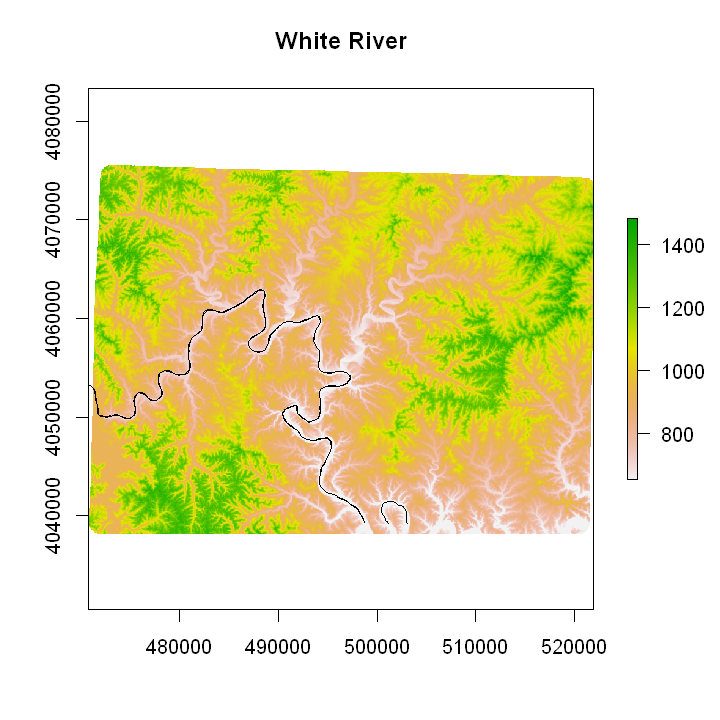

In [80]:
plot(inRas, topo.colors, main = "White River")
plot(whiteriver, add = TRUE)

Now, apply a buffer transformation to the selected river.  This can be done using the buffer() function (raster library). Remember, the distance units of this dataset are in meters.

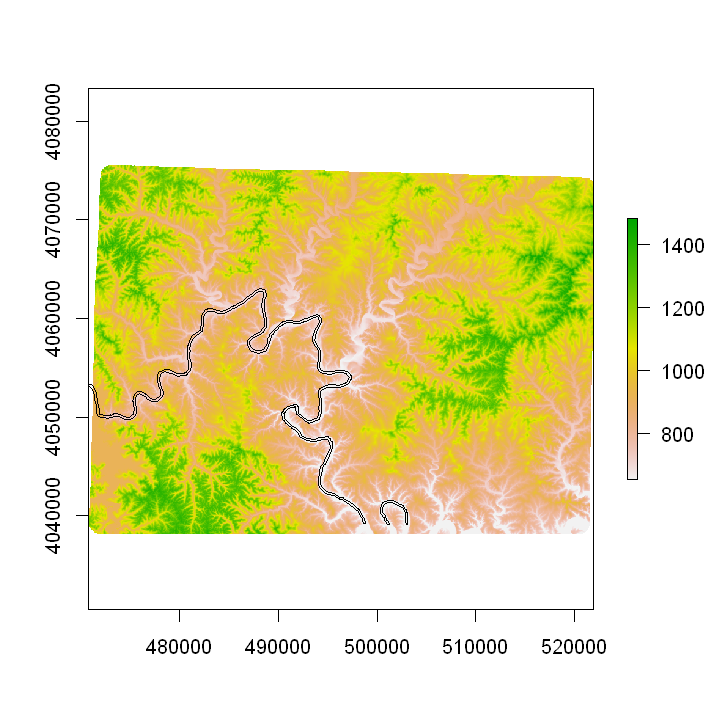

In [82]:
# buffer selected river

wrBuffer <- buffer(whiteriver, width = 100)

# replot
plot(inRas, topo.colors)
plot(wrBuffer, add = TRUE)

Based on the buffered area, use the extract() function (raster library) to extract the cell values within 100m of the river.

In [89]:
# extract the pixel values corresponding with the river

exriver <- extract(inRas, wrBuffer)

In [90]:
# unlist the extracted list
exvalues <- unlist(exriver[[1]])

In [91]:
# compute zonal stats
maxval <- max(exvalues, na.rm = T)
minval <- min(exvalues, na.rm = T)

In [92]:
print(maxval)

[1] 1009


In [93]:
print(minval)

[1] 654
